<a href="https://colab.research.google.com/github/kaylinroberts/Classifying-Bee-Wings/blob/main/Final_Report_and_Code_Bee_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# READ ME

1. Before you can run this code make sure you have installed the following packages exported in the code.

2. Download the PSTAT 199 DATASET WITH LABELS folder to your DESKTOP. Note if you download the folder to a different area on your computer you will need to redefine the file_path variable specified in the second code chunk.


# Automation of Bee Species Identification
## Kaylin Roberts
### Cheadle Center for Biodiversity & Ecological Restoration  
### 06/14/23

## Abstract

The species and/or population of a bee is an important factor for almost any research that involves bees. This project aims to automate and simplify this proccess by using 2d images of bee wings to classify bee populations and species. In this paper we will implement k-clusters on augmented images of bee wings to classify the population. We will use two different methods, Principal Component Analysis and Image Processing with the library OpenCV, to preprocess the image before fitting it to the model. We then will decide on the optimal method by comparing the results of the model performance.

## Objectives

The identification of bees is a strenuous task; it takes years of training to be able to identify these organisms and there are over 20,000 different species. Prior work has determined that wing morphometrics can distinguish not only between species but also between populations using manually-identified  “landmark” coordinates corresponding to intersections of veins in bee wings (https://escholarship.org/uc/item/2g76z3n3). For this research project, I will attempt to reproduce these distinctions using K-Means Clustering to eliminate the need to manually identify the wing morphology. There are two different methods of how the data was preprocessed before feeding it into the K-Means Cluster model. The first method is applying Principal Component Analysis to reduce the dimensions of the images and the second method is preprocessing the images using open-cv.

## Dataset Creation

The dataset consists of bee images from 4 different species. The first step is to read in the data from the folder (provided in the Google Drive) and create a dataset contained of two columns, the first column will be the species and the second column will be the data for the image, a numpy array. I also will perform a bit of preprocessing by converting all the images to grayscale before adding it to the dataframe.

In [ ]:
#importing necessary libraries
import os
import pandas as pd
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image

In [ ]:
bee_species = ['Halictus_farinosus', 'Halictus_tripartitus', 'Halictus_ligatus','Halictus_rubicundus']
species_label = []
img = []

#read in the all the images from the dataset and convert to grayscale
for bee in bee_species:
    # glob.glob(.... should be your specific file path to the folder)
    folders = glob.glob('Desktop/PSTAT199 DATASET WITH LABELS/'+ bee)
    for folder in folders:
       for f in glob.glob(folder+'/*.jpg'):
            img.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
            species_label.append(bee)

In [ ]:
#created dataframe to store data
df = pd.DataFrame()
df['Species'] = species_label
df['Image'] = img
df.head()

,Species,Image
0,Halictus_farinosus,"[[167, 166, 166, 164, 163, 163, 164, 165, 167,..."
1,Halictus_farinosus,"[[124, 124, 124, 124, 124, 124, 124, 124, 124,..."
2,Halictus_farinosus,"[[174, 175, 175, 174, 172, 170, 170, 170, 175,..."
3,Halictus_farinosus,"[[124, 124, 124, 124, 124, 124, 124, 124, 124,..."
4,Halictus_farinosus,"[[124, 124, 124, 124, 124, 124, 124, 124, 124,..."


## Methods

In this section I will create the dataset in the code. Apply the two different preprocessing methods to the dataset, PCA and opencv, and then feed both of the augmented datasets into the K-Means clustering model.

### Data Preprocessing

In this step I will be standardizing the images by resizing and adding padding to all the images so they are of the same dimension. The code below demonstrates the process for a single image. This step is needed in order to feed our images into the K-Means Clustering Model.

In [ ]:
#Find the average height of each image.
#use the average to resize all the images to have the same width
xs =[]
for image in df['Image']:
    x = image.shape[0]
    xs.append(x)
#we need to round the average to the nearest pixel
avg_height = np.round(np.mean(xs))

In [ ]:
avg_height

424.0

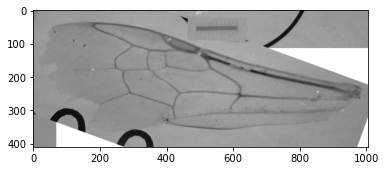

In [ ]:
# Displaying the original image with no modifcations
plt.imshow(image,cmap = 'gray')

In [ ]:
#original dimensions
image.shape

(410, 1006)

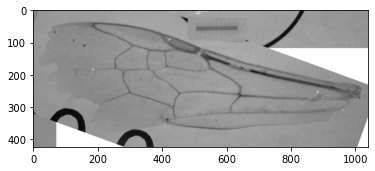

In [ ]:
from skimage.transform import resize
#calculating the aspect ratio so we can resize the length of the image without having distort the image
aspect_ratio = image.shape[1] / image.shape[0]
#resizing the image axis to have the height equal the rounded mean from above and length of image matches the same ratio as the original dimensions
resized_image = resize(image, (avg_height,int(avg_height*aspect_ratio)))
plt.imshow(resized_image,cmap = 'gray')

In [ ]:
#we can now see the new dimensions of the image have a height of 424 pixels and y axis was
# increased from 1006 to 1040 to keep the ratio consistent
resized_image.shape

(424, 1040)

In [ ]:
#now we are going to do this process for ALL the images
resized_images = []
for i in range(0,df.shape[0]):
    image = df.iloc[i,1]
    aspect_ratio = image.shape[1] / image.shape[0]
    resized_image = resize(image, (avg_height,  int(avg_height*aspect_ratio)))
    resized_images.append(resized_image)

Now that all our images have new dimensions, we are going to iterate through and find the longest image which we will call y_max. Since our height of the images all match from the previous step, all we need to do is add padding to the length of the image until it matches y_max so that all our images are of the same dimension. The final dimensions for all our images will be [avg_height , y_max].

In [ ]:
#find the largest y
y_max = 0
for image in resized_images:
    if image.shape[1]>y_max:
        y_max = image.shape[1]

y_max

1214

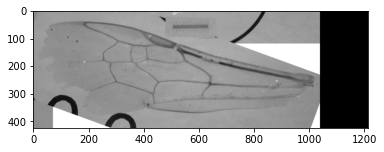

In [ ]:
#resize image with padding to make it match the max dimensions [424,1214]
image_resize = cv2.copyMakeBorder(image, top = 0, left = 0, right = abs(y_max- image.shape[1]), bottom =0, borderType = cv2.BORDER_CONSTANT)
plt.imshow(image_resize,cmap = 'gray')

In [ ]:
#performing the former steps to all the images in the dataset = []
images_border = []
for images in resized_images:
    # make images of all the same dimension[424,1223] by adding padding to the images
    image_border = cv2.copyMakeBorder(images, top = 0, left = 0, right = abs(y_max- images.shape[1]), bottom =0, borderType = cv2.BORDER_CONSTANT)
    images_border.append(image_border)

In [ ]:
#pulling a random image from the images_border array to show the new dimensions
images_border[73].shape

(424, 1214)

### Method 1:  PCA

Before I feed the images into the K-Means Clustering Model, I want to apply Principal Componenet Analysis. Essentially what I am doing is reducing the dimensions of the images by pulling out the most important components. Then I will feed the reduced images to the model.

How many principal components do we need to effectively compress our images?

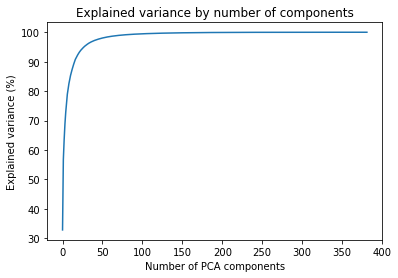

In [ ]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Calculate 382 first principal components
pca = PCA(n_components=382).fit(image)

# Collect the explained variance of each component
explained_variance = pca.explained_variance_ratio_

# Component indices
components = [i for i in range(0, len(explained_variance))]

# Explained variance in percents
explained_variance_percent = [100 * i for i in explained_variance]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Explained variance by number of components')
ax.set_ylabel('Explained variance (%)')
ax.set_xlabel('Number of PCA components')

# Cumulative sum of the explained variance
ax.plot(components, np.cumsum(explained_variance_percent))

The plot above shows us how many components are needed to achieve explained variance. As shown, 99 percent of the variance explained is avaiablable within the first 130 components or so.

Explain which components we should use:

In [ ]:
cumsum_var_explained = np.cumsum(explained_variance_percent)
cumsum_explained_variance = list(np.cumsum(explained_variance_percent))
formatted_explained_variance =[ '%.1f' % elem for elem in cumsum_explained_variance ]

Text(0.5, 1.0, 'Original image')

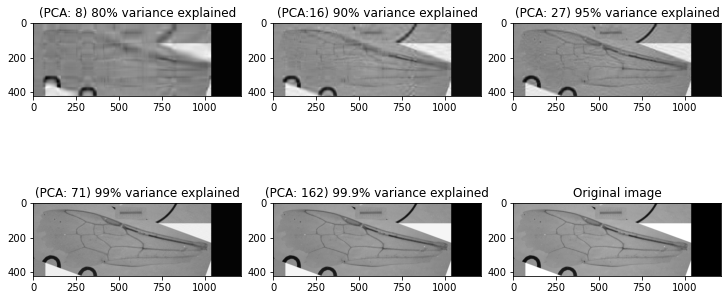

In [ ]:
#using values from the formatted_explained_variance, I will plot the images with different number of components
#to demonstrate

# Utility function that compresses image with given number # of principal components
def compress_image(n_components, image):
    pca = PCA(n_components=n_components)
    image_compressed = pca.fit_transform(image)
    return pca.inverse_transform(image_compressed)

# Compress images with different numbers of principal components
image_80 = compress_image(8, image_resize) #80% variance
image_90 = compress_image(16, image_resize) #90% variance
image_95 = compress_image(27, image_resize) #95% variance
image_99 = compress_image(71, image_resize) #99% variance
image_999 = compress_image(162, image_resize) #99.9% variance


fig, axes = plt.subplots(2,3, figsize=(10,5), constrained_layout=True)

axes[0][0].imshow(image_80, cmap='gray')
axes[0][0].set_title("(PCA: 8) 80% variance explained")

axes[0][1].imshow(image_90, cmap='gray')
axes[0][1].set_title("(PCA:16) 90% variance explained")

axes[0][2].imshow(image_95, cmap='gray')
axes[0][2].set_title("(PCA: 27) 95% variance explained")

axes[1][0].imshow(image_99, cmap='gray')
axes[1][0].set_title("(PCA: 71) 99% variance explained")

axes[1][1].imshow(image_999, cmap='gray')
axes[1][1].set_title("(PCA: 162) 99.9% variance explained")

axes[1][2].imshow(image_resize, cmap='gray')
axes[1][2].set_title("Original image")

#code source: https://scicoding.com/pca-using-python-image-compression/

### Method 2: Image Preprocessing

For this method we will be using computer vision techniques from the package opencv to accentuate the veins in the wings. To demonstrate the process more clearly I will start with image processing for one image.I begin  with smoothing the image to get minimize noise.

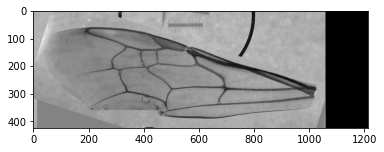

In [ ]:
images_2 = images_border
#using one
img_org = images_2[0]
plt.imshow(img_org, cmap="gray")

In this step, inorder to use open cv functions we have to change the data from image_border from float to data type uint8. But in order to accurately do this we have to scale the data since the float data ranges from 0-1 and the uint8 data ranges from 0 - 255.

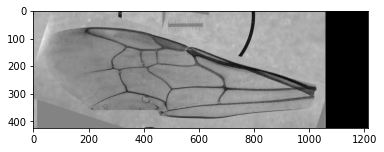

In [ ]:
scaled_data = (images_border[0] * 255).round().astype(np.uint8)
plt.imshow(scaled_data, cmap= "gray")

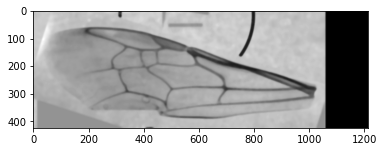

In [ ]:
#smoothing
#blurs while maintaing edges
#higher the number (9) greater the blur is
blur = cv2.bilateralFilter(scaled_data,9,75,75)
#gets rid of salt and pepper noise
#higher the number the more blurry the image is
median = cv2.medianBlur(blur,9)
#overall/averaging blur (7,7) is the kernel size in pixels that it uses to average the blur, greater kernel = greater blur
blur2 = cv2.GaussianBlur(median,(7,7),0)

plt.imshow(blur2, cmap="gray")

Next I will binarize the blurred image. What this process is doing is turning the photo from grayscale to black and white. The threshold I apply is used to determine whether a pixel is to be classified as black or white.

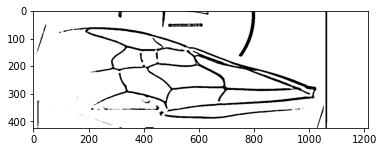

In [ ]:
#threshhold
#1st parameter: the input image
#2nd parameter: A variable of double type representing the value that is to be given if pixel value is more than the threshold value.
#3rd parameter: threshold value is the weighted sum of neighborhood values where weights are a Gaussian window.
#4th parameter: thresholdType − A variable of integer type representing the type of threshold to be used.
#5th parameter: blockSize − A variable of the integer type representing size of the pixelneighborhood used to calculate the threshold value.
# 6th parameter: C − A variable of double type representing the constant used in the both methods (subtracted from the mean or weighted mean).
mask = cv2.adaptiveThreshold(blur2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

plt.imshow(mask, cmap="gray")

Now I will do the following process for the rest of the images in the dataset

In [ ]:
rets = []
## blur and get binary image for bunch of images
for img in images_2:
    scaled= (img * 255).round().astype(np.uint8)
    blur = cv2.bilateralFilter(scaled,9,75,75)
    median = cv2.medianBlur(blur,9)
    blur2 = cv2.GaussianBlur(median,(7,7),0)
    #threshhold
    mask = cv2.adaptiveThreshold(blur2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    rets.append(mask)

### IGNORE: Used to download binary images
If you want access to binary images you can just open them in the google drive

In [ ]:
#def create_folder(folder_path):
    #os.makedirs(folder_path, exist_ok=True)

#def download_images_from_array(images_array, folder_path):
    #create_folder(folder_path)

    #for i, image_data in enumerate(rets):
        # Convert image data to PIL image
        #image = Image.fromarray(image_data)

        # Save the image to the folder
        #image_path = os.path.join(folder_path, f"image_{i}.jpg")
        #image.save(image_path)

#folder_path = "/Users/kaylinroberts/Desktop/Binary"
#download_images_from_array(image_array, folder_path)

## Preparing Data for K-Clusters

In the following steps I will prepare the data to be appropriate for feeding into a k-clusters model.

1. In order for K-Means model to work I first need to make sure all the images are of the same dimension.

1. K-Means Clustering models and PCA can only take in an array of 2 dimensions. In the following steps I resize the array from 3 dimensions to 2 dimensions by keeping the 1st dimension the same and then making the 2nd dimension equal to the product of the original 2nd and 3rd dimension.

In [ ]:
#data for PCA images
arr = np.array(images_border)
arr_2d = arr.reshape(arr.shape[0], (arr.shape[2]*arr.shape[1]))

#data for image processing images
arr2 = np.array(rets)
arr2_2d = arr2.reshape(arr2.shape[0], (arr2.shape[2]*arr2.shape[1]))
arr2_2d.shape

(186, 514736)

### K-Means Model with PCA Data

In [ ]:
#Now that we have the data in a 2d array we can perform PCA

variance = 0.95 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance,svd_solver='full')

image_compressed = pca.fit(arr_2d) #fit the data according to our PCA instance
print("Number of components before PCA  = " + str(arr_2d.shape[1]))
print("Number of components after PCA 0.95 = " + str(pca.n_components_))

#code source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Number of components before PCA  = 514736
Number of components after PCA 0.95 = 103


2. Next I will apply PCA to the 2d array, I am going to reduce the dimensions of all the images but keep 95% of the variance.

Now that we have fit our data to find the optimal number of components to retain 95% varinace, we are going to transform our data to reduce the dimensions to the number of components needed.

In [ ]:
reduced_data = pca.transform(arr_2d) #creates 186x103 matrix

In [ ]:
reduced_data.shape

(186, 103)

Now that we have prepared the data by transforming it into a 2d array and then applying dimension reduction, the data is now ready to be fit into the cluster model.

In [ ]:
from sklearn.cluster import KMeans
# 4 represents the number of different clusters we want our model to group our data into
# random state = 40 is a random seed number we choose so we can make our results reporducible.
#fit data to clusters
kmeans = KMeans(init = "k-means++",n_clusters=4,random_state=1).fit(reduced_data)

#predict the labels of clusters.
label = kmeans.fit_predict(reduced_data)

#Getting unique labels
u_labels = np.unique(label)

#df['PCA_Images'] = reduced_data
df["Cluster_Labels"] = label

### K-Means Model with Processed Image Data

In [ ]:
from sklearn.cluster import KMeans
#clusters = KMeans(4, random_state = 41)
#clusters.fit(arr2_2d)
kmeans = KMeans(init = "k-means++",n_clusters=4,random_state=1).fit(arr2_2d)

#predict the labels of clusters.
label2 = kmeans.fit_predict(arr2_2d)

#Getting unique labels
u_labels = np.unique(label2)

#Creating a second data frame and adding labels from image processing data into data frame
df2 = df.copy()
df2["Cluster_Labels"] = label2

### Results - Method 1

In [ ]:
cross_tab = df.groupby(['Species', 'Cluster_Labels']).count().reset_index().pivot(columns = 'Species', index = 'Cluster_Labels')
#replace nans with 0's
cross_tab = cross_tab.replace(np.nan,0)
cross_tab.columns = cross_tab.columns.to_flat_index()
cross_tab.columns = ['-'.join(col) for col in cross_tab.columns.values]
# Extract the second level of the column index as the new column headers
new_columns = cross_tab.columns.str.split('-').str[-1]
# Set the new column headers
cross_tab.set_axis(new_columns, axis=1, inplace=True)
cross_tab.head()

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,15.0,29.0,2.0,2.0
1,18.0,28.0,1.0,6.0
2,0.0,8.0,0.0,27.0
3,11.0,13.0,1.0,25.0


The above table shows the assigned cluster labels for the images in different species. Ideally we wanted each specie to fit one cluster. This would tell us our model was good at grouping the images by specie. But instead our results are very spread out.

In [ ]:
np.round(cross_tab.div(cross_tab.sum())*100,2).astype(str)+ '%'

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,34.09%,37.18%,50.0%,3.33%
1,40.91%,35.9%,25.0%,10.0%
2,0.0%,10.26%,0.0%,45.0%
3,25.0%,16.67%,25.0%,41.67%


The table above shows how spread out each specie is across each cluster. We can see that majority of the Halictus Farinosus is in cluster 1 with 40% and cluster 0 with 34% and the third cluster doesn't fall far behind with 25% Majority of Halictus Ligatus is in cluster 0 with 37% and 36% in cluster 1. Halictus Rubicundus is spread out across three clusters with with 50% is cluster 0. Majority of Halictus Tripartius is spread out between cluster 2 and 3, with 45% and 42% respectively.

In [ ]:
np.round(cross_tab.div(cross_tab.sum(axis = 1), axis = 0)*100,2).astype(str)+ '%'

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,31.25%,60.42%,4.17%,4.17%
1,33.96%,52.83%,1.89%,11.32%
2,0.0%,22.86%,0.0%,77.14%
3,22.0%,26.0%,2.0%,50.0%


This table we are looking at how much percentage each species make up each cluster. The table shows the Halictus Ligatus makes ups majority for cluster 0 and 1 and Halictus Tripartitus makes up majority of cluster 2 and 3.

### Results - Method 2: Image Preprocessing

In [ ]:
cross_tab2 = df2.groupby(['Species', 'Cluster_Labels']).count().reset_index().pivot(columns = 'Species', index = 'Cluster_Labels')
#replace nans with 0's
cross_tab2 = cross_tab2.replace(np.nan,0)
cross_tab2.columns = cross_tab2.columns.to_flat_index()
cross_tab2.columns = ['-'.join(col) for col in cross_tab2.columns.values]
# Extract the second level of the column index as the new column headers
new_columns = cross_tab2.columns.str.split('-').str[-1]
# Set the new column headers
cross_tab2.set_axis(new_columns, axis=1, inplace=True)
cross_tab2.head()

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,2.0,22.0,0.0,57.0
1,7.0,6.0,1.0,2.0
2,34.0,48.0,3.0,1.0
3,1.0,2.0,0.0,0.0


From the table we can see that Halictus Farinosus identifies mostly with cluster 2. Halictus Ligatus also identifies mostly with cluster 2 and but also a good amount got put into cluster 0. Majority of Halictus Rubicundus got grouped into cluster 2 but it is important to not the small sample size could skew the results. Majority of Halictus Tripartus got grouped into cluster 0.  

In [ ]:
np.round(cross_tab2.div(cross_tab2.sum())*100,2).astype(str)+ '%'

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,4.55%,28.21%,0.0%,95.0%
1,15.91%,7.69%,25.0%,3.33%
2,77.27%,61.54%,75.0%,1.67%
3,2.27%,2.56%,0.0%,0.0%


This table shows the spread of the species between each cluster. It is good that the species are mostly grouped into one cluster. Halictus Ligatus had the worst results with 28% being in one cluster and 61% being in a different cluster.  

In [ ]:
np.round(cross_tab2.div(cross_tab2.sum(axis = 1), axis = 0)*100,2).astype(str)+ '%'

,Halictus_farinosus,Halictus_ligatus,Halictus_rubicundus,Halictus_tripartitus
Cluster_Labels,,,,
0,2.47%,27.16%,0.0%,70.37%
1,43.75%,37.5%,6.25%,12.5%
2,39.53%,55.81%,3.49%,1.16%
3,33.33%,66.67%,0.0%,0.0%


This table shows the spread of each cluster. Cluster 0 is majority Halictus Tripartitus and Halictus Ligatus makes up a good portion of it as well. Cluster 1 and 2 are more spread out. Cluster 3 is made up of only 2 species which is better than the other clusters.

### Interperation of Results

To assess performance of the model I looked at two factors.
 1. How many clusters get assigned to one species .
 2. What percentage that specie makes up the cluster.

For Method 1:

1. We can look at the second table. As we can see the species are very spread out throughout the clusters and there is no clear definition of which species should belong to which cluster.

2. We will look at the third table. Halictus Farinosus is too spread out to have majority in any of the clusters. Halictus Rubicundus is also too spread out but also only contains 4 samples which makes it too small to take up majority.


For Method 2:

 1. The model did a fairly well job keep majority of the species in the same cluster. Halictus Tripartius performed the best with 95% of the the species being in one cluster. The Halictus Farinosus and Halictus Rubicundus also preformed fairly well with 75% of the sample being grouped into one cluster. The worst preforming was Laictus Ligatus but even then 62% of the species was grouped into one cluster.

 2. The model did not perform as well seperating the species into different clusters. Halictus Farinosus and Halictus Ligatus make up the majority of three clusters, 1,2, and 3. But cluster 0 was able to be mostly matched with Halictus Tripatitus with 70% being from that species.   

## Conclusions

The Principal Component Analysis did not give the results I was hoping for and that could be because the PCA is choosing other parts of the images that as more significant than the veins. Thus, when it is fed into the model, the clusters are forming based on patterns that aren't the veins. For the second method with image processing, the results look a lot more promising. Even though the image processing technique preformed well with keeping the species in one cluster, it struggled to differentiate between the species leading to overlap in clusters. For instance, while Halictus Farinosus, Halictus Ligatus, and Halictus Rubicundus got 77%, 61%, and 75% of its sample into one cluster but it was all grouped into the cluster 1. Halictus Tripartitus performed exceptionally well with getting 95% of its sample grouped into cluster 0 and making up 70% of that cluster, but this probably has to do with more the way the image was taken rather than the model's performance. While I wasn't able to achieve the results within my time frame, I believe with further work we can fit a model to distinguish between species.

## Future Work

There are many possible ways to continue with this project. My first step is to mess around with the data augmentation and try rotating, stretching, and manipulating the images before feeding it into the k-means cluster model. This way there is a less likely chance the model will pick up on the veins rather than other patterns that might be present in the standardized photos.

Another idea, but would take a lot more work, is to retake the pictures of the images. This would allow for us to use the image preprocessing method more effectively as we could plot circles on the intersections of the veins.I would have hope that once we are able to clearly define the intersections in the veins through computer vision, the results in the k-means cluster would increase significantly.

By using image processing to highlight the veins, the K-Means Cluster model is better at being able to detect the pattern we want. I think there still is much work that needs to be done, such as dialation, erosion, skeletonization, and corner detection in order to see the full potential from the K-Means Cluster model. Overall, I think this is a great start and if more work is done on this project I believe it is possible to automate the identification of species of bees.